# Build a Machine Learning Classifier:


### Introduction:

It would be very interesting to do something like predicting the champion of the tournament, but with only 127 tournaments in the dataset, I don't have good enough data to do this. Since most of my grand slam tennis project has been about best of 3 vs best of 5 sets, I think it would be interesting to be able to predict which matches last longer than 3 sets.

It seems like it would be possible to do the same thing for best of 3 set matches, but a quick probabilistic analysis shows that this is not possible. The probability of having a 2 set match is P=p1^2+(1-p1)^2, where p1 is the probability of the better player winning. The solution to this equation says that given that p1 is always greater than 0.5, P is always greater than 0.5. This means that we should always predict a 2 set match, making a machine learning algorithm redundant. By similar logic, it would be pointless to try to predict a 3,4, or 5 sets in a best of 5 set match, so the only ML classifier worth building is one which predicts if the match will be 3 sets or longer than 3 sets (i.e. 4 or 5 sets long). In that case, P=p1^3+(1-p1)^3. Solving for P=0.5, it turns out that if the probability of the better player winning the set is smaller than 0.789, then we expect the match to be longer than 3 sets, but if it is greater than 0.789, then we expect the match to be shorter than 3 sets.

Since half of all best of 5 set matches go to 3 sets, and we assume a distribution similar to a Gaussian, then we expect the p1 in most matches to be quite close to 0.789. This fact means that we expect it to be quite difficult to make an ML classifier that can regularly determine what length of match we will have. It will still be interesting to try!

### Steps:

1) I will first clean the data frame:

    a) Remove all columns which do not help to predict the length of match.
    b) Replace the player rating columns with 'higher rated' and 'lower rated' player columns to reduce redundancy.

2) Explore the relationship between the remaining columns and the length of match using plots. Further remove columns which don't show any correlation.

3) Since this is a supervised classification problem, I have chosen to use the following algorithms: decision tree classifier, random forest classifier, logistic regression, support vector classifier, and k nearest neighbors classifier. I then optimized the parameters of the k nearest neighbors algorithm.

### Brief Summary of Results:

As expected, the results were underwhelming. The optimized k nearest neighbors classifier had an accuracy of 55%. These results were as expected since the correlation between the dependent variables and the length of match was not strong. As discussed in the introduction, we expected the p1 of most matches to be around 0.789, meaning that most matches would have a good chance of being either 3 sets or more, making it hard to predict the length of match better than flipping a coin!

### 0) Import Libraries and data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import zip_longest

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df=pd.read_csv('Tennis_DataFrame.csv')

In [28]:
df.head()

,Grand Slam,Round,Player 1 Rating,Player 1,Player 1 Score,Player 2 Rating,Player 2,Player 2 Score,5-set Comeback,3-set Comeback,...,Winner 3,Rated Winner 3,Winner 1,Rated Winner 1,Rated 5-set Comeback,Rated 3-set Comeback,# of Sets,# of Sets 3,Rating Differential,Winner Rating
0,1989 a,7,9,Miloslav Mečíř,"[2, 2, 2]",2,Ivan Lendl,"[6, 6, 6]",0,0,...,-1,1,-1,1,0,0,3,2,7,2
1,1989 a,6,11,Thomas Muster,"[2, 4, 7, 5]",2,Ivan Lendl,"[6, 6, 5, 7]",0,0,...,-1,1,-1,1,0,0,4,2,9,2
2,1989 a,6,9,Miloslav Mečíř,"[7, 6, 6]",100,Jan Gunnarsson,"[5, 2, 2]",0,0,...,1,1,1,1,0,0,3,2,91,9
3,1989 a,5,100,Goran Ivanišević,"[5, 0, 3]",9,Miloslav Mečíř,"[7, 6, 6]",0,0,...,-1,1,-1,1,0,0,3,2,91,9
4,1989 a,5,14,Jonas Svensson,"[0, 3, 6, 4]",100,Jan Gunnarsson,"[6, 6, 4, 6]",0,0,...,-1,-1,-1,-1,0,0,4,2,86,100


### 1) Clean the data frame:

Drop all unuseful columns:

In [4]:
df_ml=df.drop(['Player 1', 'Player 1 Score', 'Player 2', 'Player 2 Score', 
               '5-set Comeback','3-set Comeback', 
               'Winner', 'Rated Winner', 'Winner 3','Rated Winner 3', 'Winner 1', 'Rated Winner 1', 
               'Rated 5-set Comeback','Rated 3-set Comeback',
               'Winner Rating'], 
              axis=1)

Drop all matches between two unrated players since these contain very little information about who is better. This is unfortunate because low rated players which have a close rating would be good candidates for long matches:

In [5]:
df_ml=df_ml[(df_ml['Player 1 Rating']!=100) | (df_ml['Player 2 Rating']!=100)]

Some of the ML algorithms will treat player 1 and player 2 differently, but they should treated equally (the difference between player 1 and player 2 is simply that player 1 appeared on the top of the draw and player 2 on the bottom, and this should have no effect on result). So, I'm going to put all higher rated players in one column, lower rated players in another, and drop the Player 1 Rating and player 2 Rating columns:

In [6]:
df_ml['Higher Rated']=df_ml.apply(lambda x: x['Player 1 Rating'] if x['Player 1 Rating']<x['Player 2 Rating'] else x['Player 2 Rating'],axis=1)
df_ml['Lower Rated']=df_ml.apply(lambda x: x['Player 2 Rating'] if x['Player 1 Rating']<x['Player 2 Rating'] else x['Player 1 Rating'],axis=1)
df_ml=df_ml.drop(['Player 1 Rating','Player 2 Rating'],axis=1)

Remove the 'Grand Slam' column, and use it to make year and venue columns (i.e. Australian, French, Wimbledon or US):

In [7]:
df_ml['Year']=df_ml['Grand Slam'].apply(lambda x: int(x[0:4]))
df_ml['Venue']=df_ml['Grand Slam'].apply(lambda x: x[-1])
df_ml.drop('Grand Slam',axis=1,inplace=True)

Drop all matches which didn't last at least 3 sets:

In [8]:
df_ml=df_ml[df_ml['# of Sets']>2]

View the dataframe after making these modifications:

In [9]:
df_ml

,Round,# of Sets,# of Sets 3,Rating Differential,Higher Rated,Lower Rated,Year,Venue
0,7,3,2,7,2,9,1989,a
1,6,4,2,9,2,11,1989,a
2,6,3,2,91,9,100,1989,a
3,5,3,2,91,9,100,1989,a
4,5,4,2,86,14,100,1989,a
...,...,...,...,...,...,...,...,...
15824,1,3,2,75,25,100,2020,a
15828,1,3,2,92,8,100,2020,a
15829,1,3,2,93,7,100,2020,a
15832,1,5,3,74,26,100,2020,a


### 2) Explore the relationship between length of match ('# of Sets') and the other columns

Make a function which allows us to compare the columns to the number of sets in the match:

In [10]:
def perc_category(df_ml,venue,column_name,column_name_perc):
    '''Gives the percent of matches which ended in 3,4, or 5 sets for a certain column (eg. Year)'''
    set_totals=df_ml[df_ml[column_name]==venue][column_name_perc].value_counts()
    set_totals.name=venue
    return set_totals/sum(set_totals)*100
#test:
perc_category(df_ml,2006,'Year','# of Sets')

3    51.928783
4    26.706231
5    21.364985
Name: 2006, dtype: float64

In [11]:
def make_plot(df_categories,column_name):
    '''
    Make a scatter plot of % matches which ended in either 3 or (4 or 5) sets vs one of the columns in the dataframe.
    
    Inputs:
    df_categories: dataframe with columns "# of Sets" and other columns (e.g. "Venue")
    
    Output:
    Figure: Percent Matches (which ended in 3 vs. 4 or 5 sets) vs. another column variable (e.g. Venue)
    
    '''
    fig,ax=plt.subplots()
    for ind in range(len(df_categories.index)):
        ax = plt.scatter(x=df_categories.columns,y=df_categories.iloc[ind,:])

    ax=plt.gca()
    ax.set_xlabel(column_name)
    ax.set_ylabel('Percent Matches')
    ax.legend([f'{sets} Sets' for sets in df_categories.index])

#Test:
# df_category=[perc_category(df_ml,1995,'Year') for venue in df_ml[column_name].unique()]
# df_categories=pd.DataFrame(df_category).transpose()
# make_plot(df_categories,'Venue')

Loop through each column to compare it to the # of Sets in the match (plot % of matches which had a certain length vs. the column):

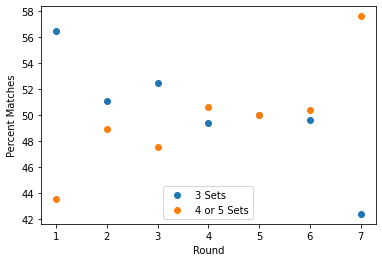

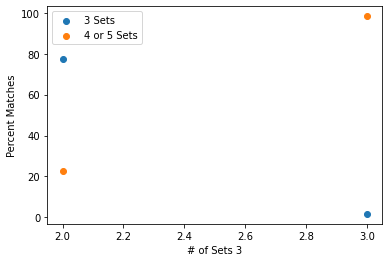

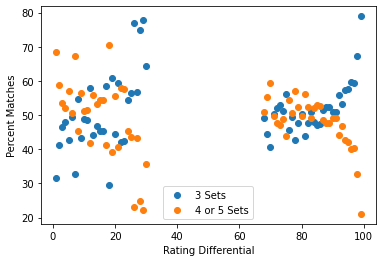

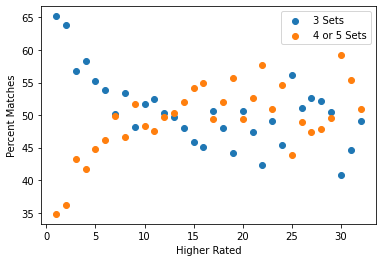

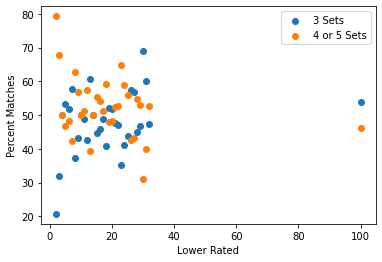

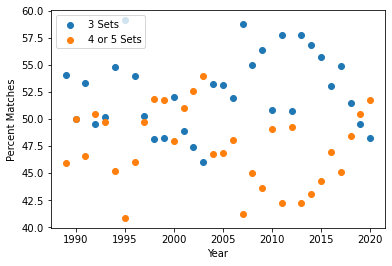

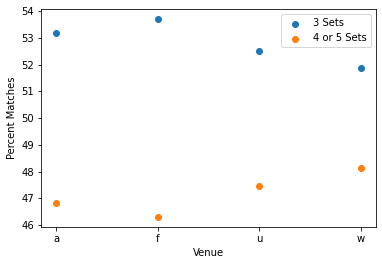

In [12]:
column_name_perc='# of Sets' #Choose which column we want to be the independent variable
for column_name in df_ml.columns:
    if column_name==column_name_perc: #We don't want to plot the same column against itself.
        pass
    else:
        #Use perc_category function in a list comprehension to make a data frame whose columns are a category (column in df_ml) 
        #and which has the percent of matches which ended in 3,4, or 5 sets in the dataframe.
        df_category=[perc_category(df_ml,venue,column_name,column_name_perc) for venue in df_ml[column_name].unique()]
        df_categories=pd.DataFrame(df_category).transpose()
        # To combine matches with 4 and 5 sets (if you want to compare 3,4, and 5 sets, comment out these next three lines):
        df_categories=pd.DataFrame(df_categories.iloc[0]).transpose()
        df_categories=df_categories.append(pd.DataFrame(100-df_categories.iloc[0]).transpose(),ignore_index=True)
        df_categories.index=['3','4 or 5']
        #Plot the percent of matches which ended in 3,4, or 5 sets vs the columns in df_ml in different graphs:
        make_plot(df_categories,column_name)

There is almost no correlation between year or venue with the length of match, so we will remove those two columns. We will also remove the # of sets in a best of 3 set match since that gives us additional information which we would not have before a match (it would unfairly help our model). The remaining columns show a correlation with length of match. They are: round, the rating of the higher and lower rated players, and the rating differential between players.

In [13]:
df_ml.drop(columns='Year',axis=1,inplace=True)
df_ml.drop(columns='Venue',axis=1,inplace=True)
df_ml.drop(columns='# of Sets 3',axis=1,inplace=True)

Check to make sure columns aren't missing any values:

In [14]:
df_ml.isnull().sum()

Round                  0
# of Sets              0
Rating Differential    0
Higher Rated           0
Lower Rated            0
dtype: int64

Convert # of Sets into a binary column called Sets where 0 represents 3 sets and 1 represents 4 or 5 sets:

In [15]:
df_ml['Sets']=df_ml['# of Sets'].apply(lambda x: 0 if x==3 else 1)
df_ml.drop(columns='# of Sets',axis=1,inplace=True)

### 3) Evaluate 5 different possible ML models:
a) View models without any optimization

Split data into training and test data sets:

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
X = df_ml.drop('Sets',axis=1)
y = df_ml['Sets']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.20, random_state=101)

In [18]:
from itertools import zip_longest

In [19]:
def ml_model(X_train, X_test, y_train, y_test, model, *args,**kwargs):
    '''
    Takes training data, testing data, and a model with its parameters, returns the predictions of the model and prints
    the evaluation metrics in the form of a classification report and a confusion matrix.
    '''
    if args[0]==(0):
        instance=model() #model instantiation doesn't accept an empty tuple, so we need to accommodate the models which don't have any inputs.
    else:
        instance=model(*args,**kwargs) #Instantiate the model
    instance.fit(X_train,y_train) #Fit the model
    predictions=instance.predict(X_test) #Predict using test data
    print(f'Evaluation metrics for the {model} model:\n')
    print(classification_report(y_test,predictions))
    print(f'Confusion Matrix:\n {confusion_matrix(y_test,predictions)}\n')
    try:
        pred_prob=instance.predict_proba(X_test)
    except AttributeError:
        pred_prob=0        
    return predictions,pred_prob
#test:
predictions,pred_prob=ml_model(X_train, X_test, y_train, y_test, KNeighborsClassifier, 30,algorithm='brute')

Evaluation metrics for the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> model:

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       913
           1       0.53      0.39      0.45       856

    accuracy                           0.53      1769
   macro avg       0.53      0.53      0.52      1769
weighted avg       0.53      0.53      0.52      1769

Confusion Matrix:
 [[614 299]
 [525 331]]



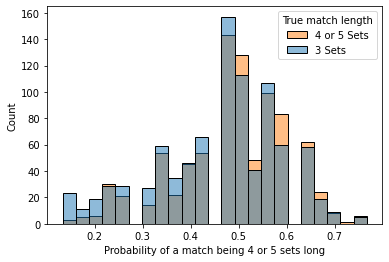

In [20]:
def plot_model_evaluation(y_test,pred_prob):
    '''
    Plot a distribution of the number of matches which are predicted to be 3 vs 4 or 5 sets (with probabilities) 
    compared to what they actually were.
    '''
    df_ml_test=df_ml.loc[y_test.index]
    df_ml_test[['0','1']]=pred_prob
    df_ml_test['Predictions']=predictions
    fig=sns.histplot(data=df_ml_test,x='1',hue='Sets')
    fig.set_xlabel('Probability of a match being 4 or 5 sets long')
    fig.legend(['4 or 5 Sets','3 Sets'],title='True match length')
    plt.show()
#Test:
plot_model_evaluation(y_test,pred_prob)

***Evaluate all of the models in one loop by printing their classification report, confusion report, and a plot of what the model thought the probability of the length of each match is:***

Evaluation metrics for the <class 'sklearn.tree._classes.DecisionTreeClassifier'> model:

              precision    recall  f1-score   support

           0       0.54      0.68      0.60       913
           1       0.53      0.39      0.45       856

    accuracy                           0.54      1769
   macro avg       0.54      0.53      0.53      1769
weighted avg       0.54      0.54      0.53      1769

Confusion Matrix:
 [[617 296]
 [522 334]]



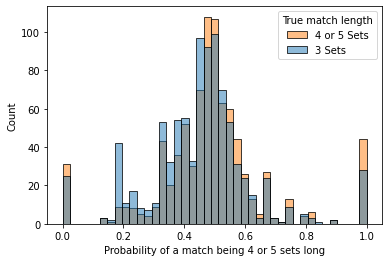

Evaluation metrics for the <class 'sklearn.ensemble._forest.RandomForestClassifier'> model:

              precision    recall  f1-score   support

           0       0.54      0.65      0.59       913
           1       0.53      0.42      0.47       856

    accuracy                           0.54      1769
   macro avg       0.54      0.54      0.53      1769
weighted avg       0.54      0.54      0.53      1769

Confusion Matrix:
 [[594 319]
 [496 360]]



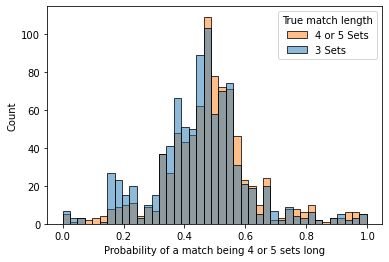

Evaluation metrics for the <class 'sklearn.linear_model._logistic.LogisticRegression'> model:

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       913
           1       0.53      0.39      0.45       856

    accuracy                           0.54      1769
   macro avg       0.54      0.53      0.53      1769
weighted avg       0.54      0.54      0.53      1769

Confusion Matrix:
 [[614 299]
 [520 336]]



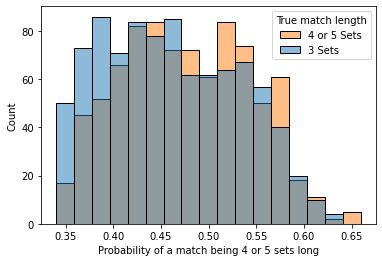

Evaluation metrics for the <class 'sklearn.svm._classes.SVC'> model:

              precision    recall  f1-score   support

           0       0.53      0.74      0.62       913
           1       0.53      0.31      0.39       856

    accuracy                           0.53      1769
   macro avg       0.53      0.53      0.51      1769
weighted avg       0.53      0.53      0.51      1769

Confusion Matrix:
 [[675 238]
 [590 266]]

Evaluation metrics for the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> model:

              precision    recall  f1-score   support

           0       0.53      0.66      0.59       913
           1       0.51      0.37      0.43       856

    accuracy                           0.52      1769
   macro avg       0.52      0.52      0.51      1769
weighted avg       0.52      0.52      0.51      1769

Confusion Matrix:
 [[605 308]
 [537 319]]



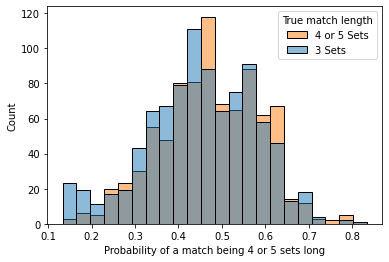

In [21]:
models=[DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, SVC, KNeighborsClassifier]
parameters=[0,0,0,0,30] #Initial parameters
for model, parameter in zip_longest(models,parameters):
    predictions,predict_proba=ml_model(X_train, X_test, y_train, y_test, model, parameter)
    if type(predict_proba)!=int: #SVC doesn't return a probability for 0 or 1, so it can't use plot_model_evaluation function.
        plot_model_evaluation(y_test,predict_proba)

All of the models give an accuracy between 52% and 54%, which is only slightly better than 50%. As expected, the models are not performing well, in large part due to the fact that most of the matches are centered around a probability of 50% (also expected), and not enough data. The k nearest neighbors model is very sensitive to the number of neighbors, so it would be interesting to try to optimize some of this models parameters.

### b) Optimize K Nearest Neighbors Algorithm:

#### Choosing a K Value:

By using the elbow method, I will find the number of nearest neighbors which minimizes the error rate (maximizes accuracy).

In [22]:
from sklearn.metrics import accuracy_score

Use a loop to try a range of values for k, then choose the one which minimizes the error rate:

In [23]:
error_rate=[]
ks=(np.linspace(0,1000,101)+1)*3 #Make a range of k values to try
for i in ks:
    KNN=KNeighborsClassifier(n_neighbors=int(i),algorithm='brute')
    KNN.fit(X_train,y_train)
    predictions=KNN.predict(X_test)
    error_rate.append(1-accuracy_score(predictions,y_test))

Create a plot with error rate vs k to find out which k minimizes the error:

Text(0, 0.5, 'Error Rate')

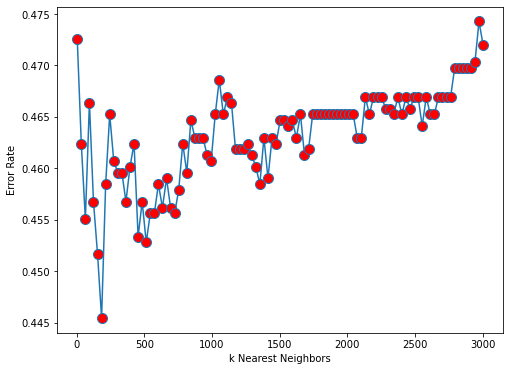

In [24]:
plt.figure(figsize=(8,6))
plt.plot(ks,error_rate,marker='o',markersize=10,linestyle='-',markerfacecolor='red')
plt.xlabel('k Nearest Neighbors')
plt.ylabel('Error Rate')

Find k value corresponding to minimum error rate:

In [25]:
arr=np.array(error_rate)
ind=np.where(arr==np.amin(arr))[0][0]
k_opt=int(ks[ind]) #k
k_opt

183

Reprint the evaluation metrics using the optimized value for k:

Evaluation metrics for the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> model:

              precision    recall  f1-score   support

           0       0.56      0.68      0.61       913
           1       0.55      0.42      0.48       856

    accuracy                           0.55      1769
   macro avg       0.55      0.55      0.54      1769
weighted avg       0.55      0.55      0.55      1769

Confusion Matrix:
 [[624 289]
 [499 357]]



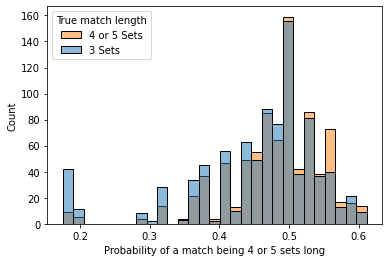

In [26]:
predictions,predict_proba=ml_model(X_train, X_test, y_train, y_test, KNeighborsClassifier, k_opt,algorithm='brute') #Instantiate model, fit model, predict values, plot evaluation metrics
plot_model_evaluation(y_test,predict_proba) #Plot number of sets vs probability of a certain number of sets, while specifying the true match length.

By optimizing the number of neareast neighbors, the accuracy of the model is 0.55, which is slightly better than the other machine learning algorithms. I used the brute force alogrithm rather than using the KDTree or BallTree algorithms because it improves the accuracy slightly, and the decrease in speed isn't significant given the relatively small size of the dataset. The reason KDTree and BallTree algorithms may be misclassifying some 'leaves' could be because of the small correlation between # of sets and round. The performance of this algorithm is not likely to be improved much beyond this level of accuracy because the correlation between the dependent variables and length of match is small. However, there are a few other ways this machine learning algorithm could be improved:

1) The best way to improve the results would be to improve the dataset itself. Having the specific world ranking of each player would be extremely helpful. Many of the games feature a nonrated player. This is a problem because unrated players actually have ratings which range between 33 and about 150, but we are giving them all the same rating of 100 (a player rated 33 in the world is obviously much better than one rated 150). This would help to give a stronger correlation between length of match and rating differential and player rating, improving the model.

2) Another approach that could improve the results would be to use the specific names of players. This may help, but there are so many different players that we probably don't have enough data to train the model without overfitting.

3) A third approach would be to optimize some more of the parameters. In the k nearest neighbors model, we could consider weighting certain matches stronger than others. For example, since we have less information in matches with unrated players, any data coming from those matches could be weighted less strongly. Similarly, we could weight points by the inverse of their distance (or by whatever function we think is appropriate). I decided not to implement these strategies as it is unlikely to have much effect on the results since many of the matches played actually included unrated players. I could also have varied the distance metric. Since I have no reason to believe my points have certain distance dependencies, I just used the default 'Minkowski metric'. 

Based on the accuracy we obtained of 55%, it is unlikely that any of the above implementations could improve the model enough to consistently predict the correct number of sets in any given match, so I did not attempt to implement them. However, if the objective of this algorithm is to find evenly matched games which go longer than 3 sets because these are more exciting to watch, we can cherry pick certain conditions (e.g. that the rating differential be less than 5, and that the lower rated player in the match be rated higher than 6). With these conditions, our model has a higher accuracy of about 72% (see below). These conditions are quite restrictive, but practically speaking, could be helpful. This is because we will typically only watch a few matches per tournament, so choosing to watch only these matches which we are relatively sure will be longer than 3 sets could be a good strategy.

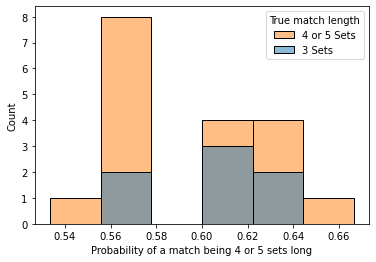

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        18

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0.72      0.60        25

[[ 0  7]
 [ 0 18]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def plot_model_evaluation_cond(y_test,pred_prob):
    '''Plot a distribution of the number of matches which are predicted to be 3 vs 4 or 5 sets compared 
    to what they actually were. Use certain conditions which ignore much of the dataset, but which optimize the chance 
    of getting a match which is longer than 3 sets.
    '''
    df_ml_test=df_ml.loc[y_test.index]
    df_ml_test[['0','1']]=pred_prob
    df_ml_test['Predictions']=predictions
    df_ml_test=df_ml_test[(df_ml_test['Rating Differential']<5) & (df_ml_test['Lower Rated']>6)]
    df_ml_test=df_ml_test[(df_ml_test['Predictions']==1)]
    df_ml_test=df_ml_test[(df_ml_test['1']>0.5)]
    fig=sns.histplot(data=df_ml_test,x='1',hue='Sets')
    fig.set_xlabel('Probability of a match being 4 or 5 sets long')
    fig.legend(['4 or 5 Sets','3 Sets'],title='True match length')
    plt.show()
    #Using conditions above
    print(classification_report(df_ml_test['Sets'],df_ml_test['Predictions']))
    print(confusion_matrix(df_ml_test['Sets'],df_ml_test['Predictions']))
#Test:
plot_model_evaluation_cond(y_test,pred_prob)